Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [3]:
dataset_name = 'Amazon_Books'
user_col = 'user_id'

In [4]:
# importa dataset 'amazon books'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])

In [5]:
data.shape

(51311621, 4)

In [6]:
data.head()

,user_id,item_id,rating,timestamp
0,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
1,0001713353,A1REUF3A1YCPHM,5.0,1112140800
2,0001713353,A1YRBRK2XM5D5,5.0,1081036800
3,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
4,0001713353,A2ZB06582NXCIV,5.0,1475452800


### Keep only high ratings

<AxesSubplot:ylabel='Frequency'>

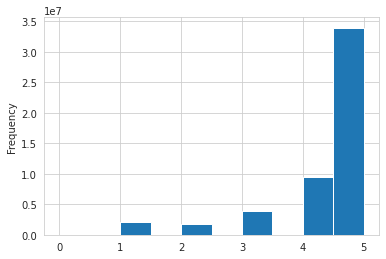

In [7]:
data['rating'].plot(kind='hist')

In [8]:
pos_ratings = np.quantile(data['rating'], q=0.8)

In [9]:
pos_ratings

5.0

In [10]:
data = data[ data['rating'] == pos_ratings ].drop(columns='rating')

In [11]:
# number of remaining cases
data.shape[0]

33979736

### Convert timestamp

In [12]:
%%time
# 56.6 s
data['date'] = data['timestamp'].apply(lambda x: datetime.fromtimestamp(x) ) # convert unix timestamp to date
data = data.sort_values(by='date') # sort by date

CPU times: user 50.7 s, sys: 4.53 s, total: 55.3 s
Wall time: 55.1 s


In [13]:
data.head()

,user_id,item_id,timestamp,date
3476836,0140125183,A2P9YDRHZTJMC3,833500800,1996-05-31
18394619,0876851898,A3CX6N6BFFV1NS,835315200,1996-06-21
12923138,0553092626,A3RTKL9KB8KLID,840240000,1996-08-17
890264,0045300232,A3RTKL9KB8KLID,843004800,1996-09-18
17596157,0806128887,A1G2W2C669C8GC,848016000,1996-11-15


In [14]:
data.tail()

,user_id,item_id,timestamp,date
51304223,B01G9NVTSI,AHJDHJFLP7CPD,1538265600,2018-09-30
51304951,B01GEXSYXQ,A18RHTVSMBC6SP,1538352000,2018-10-01
51309931,B01HB9Q7CW,A2UUXH691JARF3,1538352000,2018-10-01
51309500,B01H7ZJRNG,AEC2WVP8H25HF,1538438400,2018-10-02
51307743,B01GW712JW,A2ZXRFUDBCF5KR,1538438400,2018-10-02


In [15]:
%%time
# keep year-month
data['date'] = data['date'].apply(lambda x: datetime.strptime( str(x.year)+'-'+str(x.month), '%Y-%m' ))

CPU times: user 6min 10s, sys: 5.59 s, total: 6min 15s
Wall time: 6min 15s


## Evaluating Time defined Buckets 

Sampling the dataset

In [16]:
%%time
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()

CPU times: user 20.7 s, sys: 621 ms, total: 21.4 s
Wall time: 21.2 s


<AxesSubplot:xlabel='date'>

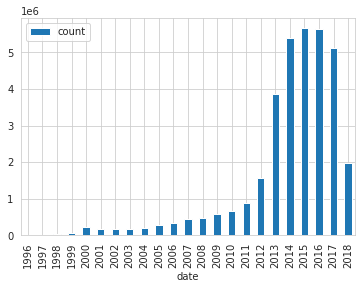

In [17]:
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.year
_.groupby('date').sum().plot(kind='bar')

In [18]:
# y_filter = (data['date'] < datetime.strptime('2018', '%Y')) & (datetime.strptime('2014', '%Y') <= data['date']) 
y_filter = (data['date'] < datetime.strptime('2014-07', '%Y-%m')) & (datetime.strptime('2014-01', '%Y-%m') <= data['date']) 

In [19]:
y_filter.sum()

2378412

In [20]:
data = data[y_filter.tolist()]

In [21]:
# number of remaining cases
data.shape[0]

2378412

Sampling the dataset - only most frequent users (overall)

In [22]:
%%time
# ( data[:1000000].groupby(by=['user_id'])['date'].nunique() > 1 ).sum()
user_freq_over_months = data.groupby(by=['user_id'])['date'].nunique()

CPU times: user 2.63 s, sys: 84.4 ms, total: 2.71 s
Wall time: 2.71 s


<AxesSubplot:ylabel='Frequency'>

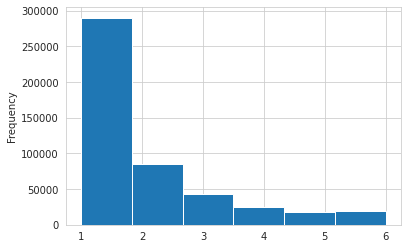

In [23]:
user_freq_over_months.plot(kind='hist',bins=user_freq_over_months.max())

In [24]:
# # we'll filter users with frequency higher than q
threshold = np.quantile(user_freq_over_months, q=0.75)
threshold

2.0

In [25]:
# there are this many users with freq above the threshold
(user_freq_over_months >= threshold).sum()

190248

In [26]:
# index of frequent users
freq_users = user_freq_over_months[user_freq_over_months >= threshold].index

In [27]:
data = data.set_index('user_id').loc[freq_users].reset_index()

In [28]:
# number of remaining cases
data.shape[0]

2031109

In [29]:
data.to_csv('output/amazonbooks_dump/sampled_amazon_books.csv', index=False)

How many interactions occur in each month / year?

CPU times: user 1.01 s, sys: 84.3 ms, total: 1.1 s
Wall time: 1.09 s


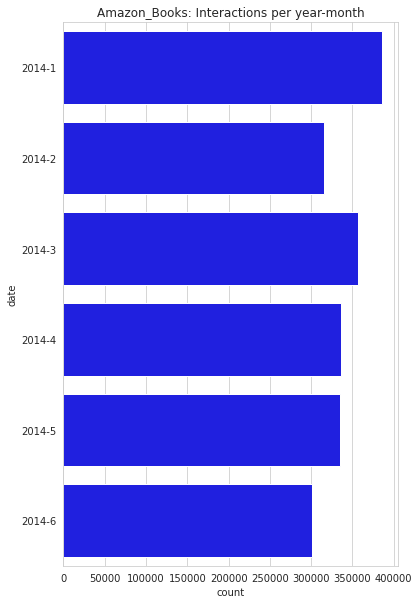

In [30]:
%%time
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [29]:
%%time
# 4h 4min 45s
# user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)
user_presence_df, user_month_interactions = get_interactions_info(data=data, user_col=user_col)

user_presence_df.to_csv('output/amazonbooks_dump/user_presence_df.csv', index=False)
user_month_interactions.to_csv('output/amazonbooks_dump/user_month_interactions.csv', index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [31]:
user_presence_df = pd.read_csv('output/amazonbooks_dump/user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonbooks_dump/user_month_interactions.csv')

In [32]:
user_presence_df.head()

,UserID,month_%
0,1410421864,1.0
1,0321934407,1.0
2,0321929500,1.0
3,0802119921,1.0
4,0425262960,1.0


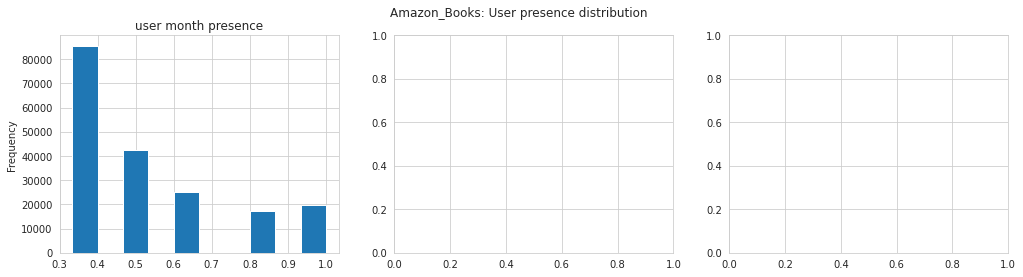

In [33]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

In [34]:
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

In [35]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [36]:
# defining threshold
frequency_threshold = 0.8

In [37]:
# frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)
frequent_users_month = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

37067 users of 190248 (19.484%) occurr in 80.0% or more months.


In [38]:
joblib.dump(frequent_users_month, 'output/amazonbooks_dump/frequent_users_month.joblib')

['output/amazonbooks_dump/frequent_users_month.joblib']

In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [ ]:
# freq_user_quarter_info = get_frequent_user_statistics(
#     interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# # freq_user_quarter_info

In [ ]:
# freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [ ]:
# freq_user_semester_info = get_frequent_user_statistics(
#     interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# # freq_user_semester_info

In [ ]:
# freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

In [ ]:
# freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [ ]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [ ]:
# # these are the users that should be used in holdouts, and only their last interactions
# # BUT, there are users that do not appear in some intervals, and some have only one interaction
# user_trimestre_interactions.loc[frequent_users_trimestre]
# user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [80]:
# n_iter_bucket = 50E3

# interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

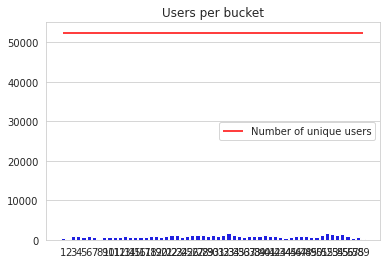

In [81]:
# plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [83]:
# %%time
# # 2h 52min 2s
# user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

CPU times: user 2h 52min 1s, sys: 1.53 s, total: 2h 52min 2s
Wall time: 2h 52min 2s


In [84]:
# frequency_threshold = 0.8

In [85]:
# frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

0 users of 52474 (0.0%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [86]:
# freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

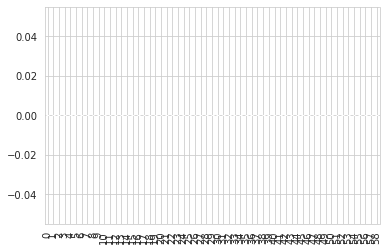

In [87]:
# freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

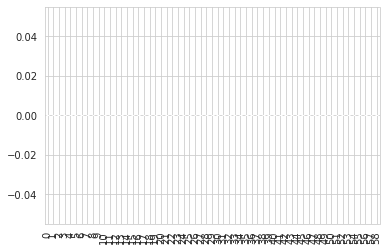

In [88]:
# freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

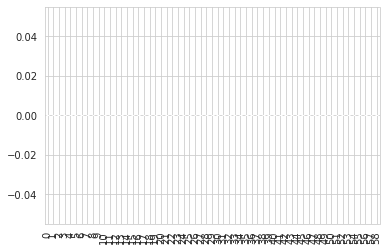

In [89]:
# frequent users interactions per bucket
# plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

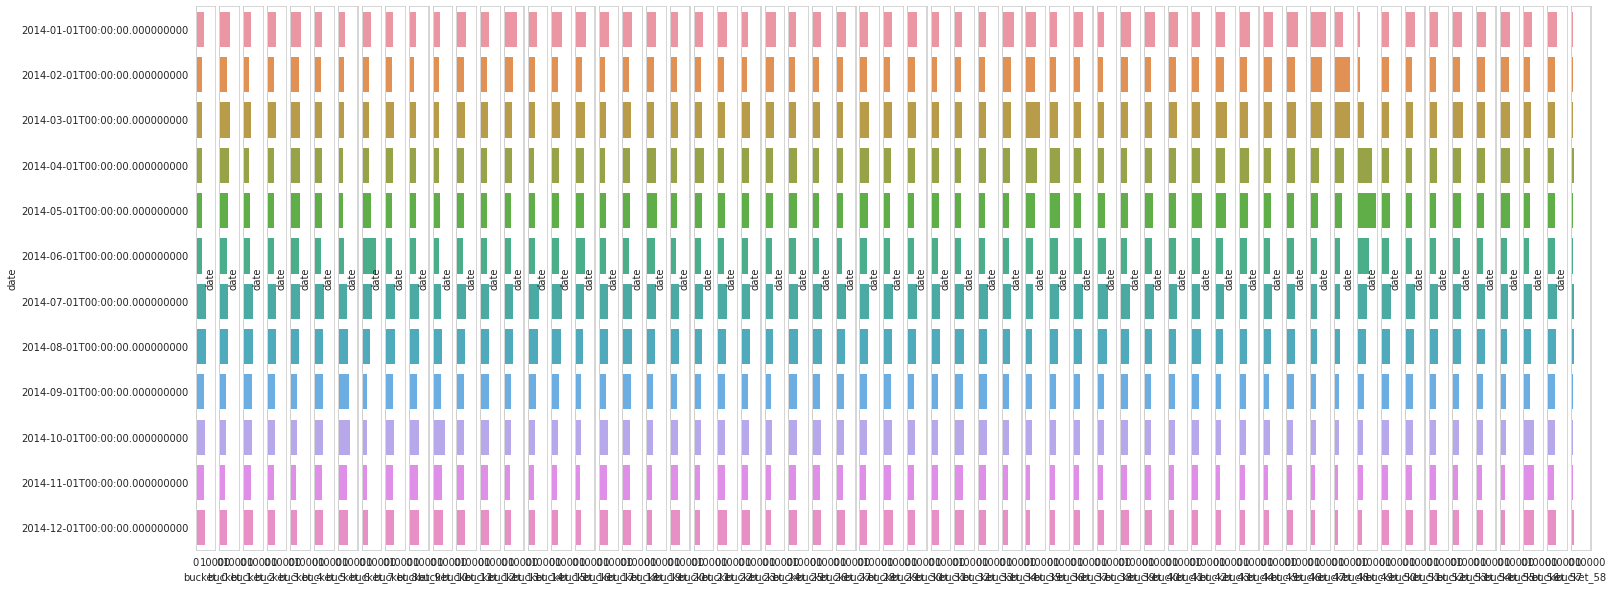

In [90]:
# plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
# # transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# # recebe listas
# stream = ImplicitData(data['user_id'], data['item_id'])

# empty_stream = ImplicitData([], [])

In [ ]:
# num_factors = 160
# num_iter = 4
# learn_rate = 0.5
# regularization = 0.4
# num_nodes = 8

In [ ]:
# # O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# # Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
# n_holdouts = int( data.shape[0]/n_iter_bucket )
# eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
# _=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
# joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)